# Library Load

In [1]:
# 필요한 PyTorch 라이브러리 불러오기
import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
from torch.autograd import Variable

import PIL
from PIL import Image
import matplotlib.pyplot as plt

import cv2
import numpy as np
import pandas as pd

import copy

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [2]:
np.random.seed(42)

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
# GPU 장치 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Data Load

In [5]:
# Style Image Path
style_img_path = './style_img/'
style_img_list = os.listdir(style_img_path)
len(style_img_list)

114

In [6]:
style_img_list

['b01.jpg',
 'b02.jpg',
 'b03.jpg',
 'b04.jpg',
 'b05.jpg',
 'b06.jpg',
 'b07.jpg',
 'b08.jpg',
 'b09.jpg',
 'b10.jpg',
 'b100.jpg',
 'b101.jpg',
 'b102.jpg',
 'b103.jpg',
 'b104.jpg',
 'b105.jpg',
 'b106.jpg',
 'b107.jpg',
 'b108.jpg',
 'b109.jpg',
 'b11.jpg',
 'b110.jpg',
 'b111.jpg',
 'b112.jpg',
 'b113.jpg',
 'b114.jpg',
 'b12.jpg',
 'b13.jpg',
 'b14.jpg',
 'b15.jpg',
 'b16.jpg',
 'b17.jpg',
 'b18.jpg',
 'b19.jpg',
 'b20.jpg',
 'b21고누놀이.jpg',
 'b22금강사군첩.jpg',
 'b23기와이기.jpg',
 'b24길쌈.jpg',
 'b25나들이.jpg',
 'b26나룻배.jpg',
 'b27논갈이.jpg',
 'b28늦은 밤 피리부는 선인.jpg',
 'b29담배썰기.jpg',
 'b30대장간.jpg',
 'b31벼타작.jpg',
 'b32병진년화첩-옥순봉도.jpg',
 'b33빨래터.jpg',
 'b34소림명월도.jpg',
 'b35송호도.jpg',
 'b36신선과 사슴.jpg',
 'b37신행길.jpg',
 'b38연광정연회도.jpg',
 'b39자리짜기.jpg',
 'b40장터길.jpg',
 'b41점심.jpg',
 'b42주막.jpg',
 'b43처용무.jpg',
 'b44편자박기.jpg',
 'b45하화청정도.jpg',
 'b46행상.jpg',
 'b47활쏘기.jpg',
 'b48황묘농접도.jpg',
 'b49.jpg',
 'b50.jpg',
 'b51.jpg',
 'b52.jpg',
 'b53.jpg',
 'b54.jpg',
 'b55.jpg',
 'b56.jpg',
 'b57.jpg',
 'b58.

# Gram Matrix Extraction

In [7]:
# 뉴럴 네트워크 모델을 불러옵니다.
cnn = models.vgg19(pretrained=True).features.to(device).eval()
print(cnn)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [8]:
# 이미지를 불러와 다운받아 텐서(Tensor) 객체로 변환하는 함수
def image_loader(img_path, imsize):
    loader = transforms.Compose([
        transforms.Resize(imsize), # 이미지의 크기를 변경
        transforms.ToTensor() # torch.Tensor 형식으로 변경 [0, 255] → [0, 1]
    ])
    image = PIL.Image.open(img_path)
    # 네트워크 입력에 들어갈 이미지에 배치 목적의 차원(dimension) 추가
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float) # GPU로 올리기


# torch.Tensor 형태의 이미지를 화면에 출력하는 함수
def imshow(tensor):
    # matplotlib는 CPU 기반이므로 CPU로 옮기기
    image = tensor.cpu().clone()
    # torch.Tensor에서 사용되는 배치 목적의 차원(dimension) 제거
    image = image.squeeze(0)
    # PIL 객체로 변경 
    image = transforms.ToPILImage()(image)
    # 이미지를 화면에 출력(matplotlib는 [0, 1] 사이의 값이라고 해도 정상적으로 처리)
    plt.imshow(image)
    plt.show()

In [9]:
# 입력 정규화(Normalization)를 위한 초기화
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().view(-1, 1, 1)
        self.std = std.clone().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [10]:
def gram_matrix(input):
    # a는 배치 크기, b는 특징 맵의 개수, (c, d)는 특징 맵의 차원을 의미
    a, b, c, d = input.size()
    # 논문에서는 i = 특징 맵의 개수, j = 각 위치(position)
    features = input.view(a * b, c * d)
    # 행렬 곱으로 한 번에 Gram 내적 계산 가능
    G = torch.mm(features, features.t())
    # Normalize 목적으로 값 나누기
    return G.div(a * b * c * d)

In [11]:
cnn = copy.deepcopy(cnn)
normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)

# 가장 먼저 입력 이미지가 입력 정규화(input normalization)를 수행하도록
model = nn.Sequential(normalization)

# 현재 CNN 모델에 포함되어 있는 모든 레이어를 확인하며
i = 0
for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
        i += 1
        name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
        name = 'relu_{}'.format(i)
        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)
    else:
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)
    print(model)
    print('='*60)

Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU()
)
Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU()
)
Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

In [12]:
model

Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_5): ReLU()
  (conv_6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_6): ReLU()
  (conv_7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_7): ReLU()
  (conv_8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_8): ReLU()
  (po

In [13]:
feature_model = model[:12]

In [14]:
feature_model

Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [15]:
gram_matrix_list = []

for name in tqdm(style_img_list):
    img_size = PIL.Image.open(style_img_path + name).size
    style_img = image_loader(style_img_path + name, (img_size[1], img_size[0]))
    
    target_feature = feature_model(style_img).detach()
    print(target_feature.shape)
    
    GRAM_MATRIX = gram_matrix(target_feature)
    print(GRAM_MATRIX.shape)
    GRAM_MATRIX = GRAM_MATRIX.to('cpu')
    GRAM_MATRIX = GRAM_MATRIX.numpy()
    print(GRAM_MATRIX.shape)
    
    gram_matrix_list.append(GRAM_MATRIX)

  0%|                                                                                          | 0/114 [00:00<?, ?it/s]

torch.Size([1, 256, 500, 322])


  2%|█▍                                                                                | 2/114 [00:02<02:16,  1.22s/it]

torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 272, 500])
torch.Size([256, 256])
(256, 256)


  3%|██▏                                                                               | 3/114 [00:03<01:25,  1.31it/s]

torch.Size([1, 256, 356, 500])
torch.Size([256, 256])
(256, 256)


  4%|██▉                                                                               | 4/114 [00:03<01:00,  1.80it/s]

torch.Size([1, 256, 405, 500])
torch.Size([256, 256])
(256, 256)


  4%|███▌                                                                              | 5/114 [00:03<00:52,  2.09it/s]

torch.Size([1, 256, 500, 487])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 500, 181])


  6%|█████                                                                             | 7/114 [00:03<00:32,  3.33it/s]

torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 500, 230])
torch.Size([256, 256])
(256, 256)


  7%|█████▊                                                                            | 8/114 [00:04<00:30,  3.45it/s]

torch.Size([1, 256, 426, 500])
torch.Size([256, 256])
(256, 256)


  8%|██████▍                                                                           | 9/114 [00:04<00:30,  3.48it/s]

torch.Size([1, 256, 425, 500])
torch.Size([256, 256])
(256, 256)


  9%|███████                                                                          | 10/114 [00:04<00:29,  3.55it/s]

torch.Size([1, 256, 431, 500])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 500, 250])


 10%|███████▊                                                                         | 11/114 [00:04<00:25,  4.02it/s]

torch.Size([256, 256])
(256, 256)


 11%|████████▌                                                                        | 12/114 [00:05<00:24,  4.09it/s]

torch.Size([1, 256, 349, 500])
torch.Size([256, 256])
(256, 256)


 11%|█████████▏                                                                       | 13/114 [00:05<00:25,  4.02it/s]

torch.Size([1, 256, 421, 500])
torch.Size([256, 256])
(256, 256)


 13%|██████████▋                                                                      | 15/114 [00:05<00:20,  4.80it/s]

torch.Size([1, 256, 348, 500])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 177, 500])
torch.Size([256, 256])
(256, 256)


 14%|███████████▎                                                                     | 16/114 [00:06<00:20,  4.70it/s]

torch.Size([1, 256, 500, 362])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 500, 229])


 15%|████████████                                                                     | 17/114 [00:06<00:19,  4.98it/s]

torch.Size([256, 256])
(256, 256)


 16%|████████████▊                                                                    | 18/114 [00:06<00:21,  4.49it/s]

torch.Size([1, 256, 425, 500])
torch.Size([256, 256])
(256, 256)


 17%|█████████████▌                                                                   | 19/114 [00:06<00:22,  4.16it/s]

torch.Size([1, 256, 420, 500])
torch.Size([256, 256])
(256, 256)


 18%|██████████████▏                                                                  | 20/114 [00:07<00:23,  4.02it/s]

torch.Size([1, 256, 411, 500])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 143, 123])
torch.Size([256, 256])
(256, 256)


 19%|███████████████▋                                                                 | 22/114 [00:07<00:17,  5.22it/s]

torch.Size([1, 256, 352, 500])
torch.Size([256, 256])
(256, 256)


 20%|████████████████▎                                                                | 23/114 [00:07<00:18,  4.91it/s]

torch.Size([1, 256, 343, 500])
torch.Size([256, 256])
(256, 256)


 24%|███████████████████▏                                                             | 27/114 [00:07<00:10,  8.14it/s]

torch.Size([1, 256, 424, 500])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 158, 136])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 152, 136])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 170, 141])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 132, 111])
torch.Size([256, 256])
(256, 256)


 25%|████████████████████▌                                                            | 29/114 [00:08<00:09,  8.92it/s]

torch.Size([1, 256, 261, 500])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 417, 500])
torch.Size([256, 256])
(256, 256)


 27%|██████████████████████                                                           | 31/114 [00:08<00:13,  5.97it/s]

torch.Size([1, 256, 500, 418])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 207, 500])
torch.Size([256, 256])


 28%|██████████████████████▋                                                          | 32/114 [00:08<00:13,  6.15it/s]

(256, 256)


 29%|███████████████████████▍                                                         | 33/114 [00:09<00:15,  5.30it/s]

torch.Size([1, 256, 426, 500])
torch.Size([256, 256])
(256, 256)


 30%|████████████████████████▏                                                        | 34/114 [00:09<00:16,  4.85it/s]

torch.Size([1, 256, 426, 500])
torch.Size([256, 256])
(256, 256)


 44%|███████████████████████████████████▌                                             | 50/114 [00:09<00:02, 24.77it/s]

torch.Size([1, 256, 373, 500])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 77, 67])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 56, 78])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 78, 67])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 79, 67])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 78, 67])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 78, 67])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 78, 67])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 56, 78])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 78, 67])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 78, 67])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 78, 67])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 66, 78])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 78, 67])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 67, 78])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 78, 67])
torch.Size([256, 256])
(

 55%|████████████████████████████████████████████▊                                    | 63/114 [00:09<00:01, 42.14it/s]

torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 43, 73])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 78, 67])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 56, 78])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 79, 65])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 78, 68])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 79, 56])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 79, 67])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 67, 78])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 78, 67])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 78, 67])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 53, 79])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 175, 150])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 428, 500])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 175, 150])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 500, 427])
torch.Size([256, 256])
(256, 256)
torch.Size([1

 61%|█████████████████████████████████████████████████▋                               | 70/114 [00:11<00:03, 13.58it/s]

torch.Size([1, 256, 424, 500])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 500, 279])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 500, 319])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 129, 500])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 397, 500])
torch.Size([256, 256])
(256, 256)


 67%|██████████████████████████████████████████████████████                           | 76/114 [00:12<00:03,  9.86it/s]

torch.Size([1, 256, 420, 500])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 500, 188])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 382, 500])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 157, 500])
torch.Size([256, 256])
(256, 256)


 70%|████████████████████████████████████████████████████████▊                        | 80/114 [00:12<00:03,  9.01it/s]

torch.Size([1, 256, 500, 222])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 182, 500])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 500, 194])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 263, 500])
torch.Size([256, 256])
(256, 256)


 73%|██████████████████████████████████████████████████████████▉                      | 83/114 [00:13<00:03,  8.40it/s]

torch.Size([1, 256, 500, 234])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 500, 218])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 185, 500])
torch.Size([256, 256])
(256, 256)


 75%|█████████████████████████████████████████████████████████████                    | 86/114 [00:13<00:03,  7.95it/s]

torch.Size([1, 256, 500, 253])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 500, 208])
torch.Size([256, 256])
(256, 256)


 77%|██████████████████████████████████████████████████████████████▌                  | 88/114 [00:14<00:03,  7.42it/s]

torch.Size([1, 256, 347, 500])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 500, 236])

 79%|███████████████████████████████████████████████████████████████▉                 | 90/114 [00:14<00:03,  7.34it/s]


torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 500, 191])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 500, 403])
torch.Size([256, 256])
(256, 256)


 81%|█████████████████████████████████████████████████████████████████▎               | 92/114 [00:15<00:03,  6.20it/s]

torch.Size([1, 256, 355, 500])
torch.Size([256, 256])
(256, 256)


 82%|██████████████████████████████████████████████████████████████████               | 93/114 [00:15<00:03,  5.69it/s]

torch.Size([1, 256, 427, 500])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 500, 226])
torch.Size([256, 256])


 83%|███████████████████████████████████████████████████████████████████▌             | 95/114 [00:15<00:03,  5.83it/s]

(256, 256)
torch.Size([1, 256, 454, 286])
torch.Size([256, 256])
(256, 256)


 84%|████████████████████████████████████████████████████████████████████▏            | 96/114 [00:15<00:03,  5.51it/s]

torch.Size([1, 256, 346, 500])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 500, 226])
torch.Size([256, 256])


 86%|█████████████████████████████████████████████████████████████████████▋           | 98/114 [00:16<00:02,  5.76it/s]

(256, 256)
torch.Size([1, 256, 500, 241])
torch.Size([256, 256])
(256, 256)


 88%|██████████████████████████████████████████████████████████████████████▏         | 100/114 [00:16<00:02,  5.95it/s]

torch.Size([1, 256, 351, 500])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 182, 500])
torch.Size([256, 256])
(256, 256)


 89%|██████████████████████████████████████████████████████████████████████▉         | 101/114 [00:16<00:02,  5.23it/s]

torch.Size([1, 256, 406, 500])
torch.Size([256, 256])
(256, 256)


 89%|███████████████████████████████████████████████████████████████████████▌        | 102/114 [00:16<00:02,  4.91it/s]

torch.Size([1, 256, 372, 500])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 500, 214])
torch.Size([256, 256])
(256, 256)


 91%|████████████████████████████████████████████████████████████████████████▉       | 104/114 [00:17<00:02,  4.57it/s]

torch.Size([1, 256, 431, 500])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 500, 246])


 92%|█████████████████████████████████████████████████████████████████████████▋      | 105/114 [00:17<00:01,  4.99it/s]

torch.Size([256, 256])
(256, 256)


 93%|██████████████████████████████████████████████████████████████████████████▍     | 106/114 [00:17<00:01,  4.57it/s]

torch.Size([1, 256, 500, 388])
torch.Size([256, 256])
(256, 256)


 94%|███████████████████████████████████████████████████████████████████████████     | 107/114 [00:18<00:01,  4.20it/s]

torch.Size([1, 256, 500, 431])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 500, 251])


 96%|████████████████████████████████████████████████████████████████████████████▍   | 109/114 [00:18<00:00,  5.05it/s]

torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 500, 229])
torch.Size([256, 256])
(256, 256)


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 110/114 [00:18<00:00,  4.69it/s]

torch.Size([1, 256, 395, 500])
torch.Size([256, 256])
(256, 256)


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 112/114 [00:19<00:00,  5.26it/s]

torch.Size([1, 256, 347, 500])
torch.Size([256, 256])
(256, 256)
torch.Size([1, 256, 190, 500])
torch.Size([256, 256])
(256, 256)


 99%|███████████████████████████████████████████████████████████████████████████████▎| 113/114 [00:19<00:00,  4.74it/s]

torch.Size([1, 256, 404, 500])
torch.Size([256, 256])
(256, 256)


100%|████████████████████████████████████████████████████████████████████████████████| 114/114 [00:19<00:00,  5.85it/s]

torch.Size([1, 256, 500, 264])
torch.Size([256, 256])
(256, 256)


In [16]:
len(gram_matrix_list)

114

# K-Means

In [17]:
data = {}

for style, gram in tqdm(zip(style_img_list, gram_matrix_list)):
    data[style] = gram

114it [00:00, ?it/s]


In [18]:
data

{'b01.jpg': array([[ 0.01665387, -0.00460237, -0.00438314, ..., -0.00327673,
          0.00052889, -0.00252655],
        [-0.00460237,  0.06756994,  0.01037986, ...,  0.00106901,
         -0.00134396, -0.01411994],
        [-0.00438314,  0.01037986,  0.01942222, ...,  0.0007324 ,
         -0.00193583, -0.0069167 ],
        ...,
        [-0.00327673,  0.00106901,  0.0007324 , ...,  0.03768617,
         -0.00150939,  0.00050153],
        [ 0.00052889, -0.00134396, -0.00193583, ..., -0.00150939,
          0.03574582, -0.00132985],
        [-0.00252655, -0.01411994, -0.0069167 , ...,  0.00050153,
         -0.00132985,  0.04403799]], dtype=float32),
 'b02.jpg': array([[ 0.04221762, -0.00867174, -0.01583532, ..., -0.01158446,
         -0.00271553, -0.00410667],
        [-0.00867174,  0.06652595,  0.01046396, ...,  0.01522296,
         -0.00684379,  0.02943474],
        [-0.01583532,  0.01046396,  0.03385571, ...,  0.00698373,
          0.00044413, -0.00103135],
        ...,
        [-0.01158

In [19]:
# get a list of the filenames
filenames = np.array(list(data.keys()))
print(filenames.shape)

# get a list of just the features
feat = np.array(list(data.values()))
print(feat.shape)

feat_resh = feat.reshape(114, -1)
print(feat_resh.shape)

(114,)
(114, 256, 256)
(114, 65536)


In [20]:
#kmeans = KMeans(n_clusters=3, n_jobs=8, random_state=42, max_iter=100)
kmeans = KMeans(n_clusters=3, n_jobs=8, random_state=42)
kmeans.fit(feat_resh)

D:\Anaconda3\envs\oriental_v1\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


KMeans(n_clusters=3, n_jobs=8, random_state=42)

In [21]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 2, 1, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [22]:
len(kmeans.labels_)

114

In [23]:
kmeans.cluster_centers_

array([[ 0.04166927, -0.00539597, -0.01604619, ...,  0.00773096,
         0.00355729,  0.05958238],
       [ 0.13243957, -0.03661051, -0.04479899, ...,  0.09734885,
        -0.02457084,  0.27106723],
       [ 0.06503568, -0.00984312, -0.01953047, ...,  0.04698005,
        -0.02642296,  0.12430751]], dtype=float32)

In [24]:
kmeans.cluster_centers_.shape

(3, 65536)

In [25]:
kmeans.cluster_centers_[0].shape

(65536,)

In [26]:
gram_matrix_list[0].reshape(-1, ).shape

(65536,)

## dissimilarity style extraction

## cluster & image mapping

In [27]:
groups = {}

for file, cluster in zip(filenames, kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [28]:
groups

{0: ['b01.jpg',
  'b02.jpg',
  'b03.jpg',
  'b04.jpg',
  'b05.jpg',
  'b06.jpg',
  'b08.jpg',
  'b09.jpg',
  'b10.jpg',
  'b100.jpg',
  'b101.jpg',
  'b102.jpg',
  'b103.jpg',
  'b104.jpg',
  'b105.jpg',
  'b106.jpg',
  'b107.jpg',
  'b108.jpg',
  'b109.jpg',
  'b110.jpg',
  'b111.jpg',
  'b112.jpg',
  'b113.jpg',
  'b14.jpg',
  'b15.jpg',
  'b16.jpg',
  'b18.jpg',
  'b19.jpg',
  'b20.jpg',
  'b49.jpg',
  'b50.jpg',
  'b51.jpg',
  'b52.jpg',
  'b53.jpg',
  'b54.jpg',
  'b55.jpg',
  'b56.jpg',
  'b57.jpg',
  'b58.jpg',
  'b59.jpg',
  'b60.jpg',
  'b61.jpg',
  'b62.jpg',
  'b63.jpg',
  'b64.jpg',
  'b65.jpg',
  'b66.jpg',
  'b67.jpg',
  'b68.jpg',
  'b69.jpg',
  'b70.jpg',
  'b71.jpg',
  'b72.jpg',
  'b73.jpg',
  'b74.jpg',
  'b76.jpg',
  'b77.jpg',
  'b78.jpg',
  'b79.jpg',
  'b80.jpg',
  'b81.jpg',
  'b82.jpg',
  'b83.jpg',
  'b84.jpg',
  'b85.jpg',
  'b86.jpg',
  'b87.jpg',
  'b88.jpg',
  'b89.jpg',
  'b90.jpg',
  'b91.jpg',
  'b92.jpg',
  'b93.jpg',
  'b94.jpg',
  'b95.jpg',
  'b96.j

## centroid style extraction

In [29]:
dissim_img_idx = []

for idx, cen in tqdm(enumerate(kmeans.cluster_centers_)):
    tmp_list = []
    for gram in feat_resh:
        tmp_list.append(abs((cen - gram)).sum())
        print((cen - gram).sum())
    print(np.argmin(tmp_list))
    dissim_img_idx.append(np.argmin(tmp_list))

3it [00:00, 16.50it/s]

197.824
89.88291
324.87793
631.7533
-244.2816
-76.58911
-242.11395
125.979126
-118.919075
-114.054535
407.3142
13.081387
-168.21231
-343.04218
-39.09998
-380.98758
-372.42065
-148.83722
243.27103
-253.3353
-1099.2821
-518.3844
-295.53943
-70.560745
-467.98743
-1138.2684
-2516.9224
-493.81412
103.52665
-257.35614
345.1112
-811.23804
-139.11995
0.4272051
-370.98877
-804.53253
-929.4994
-711.15765
-206.22925
-470.64972
-81.80892
-794.2007
-437.90167
-333.09656
-635.94794
-753.892
-1575.6559
-515.76074
-2270.3364
-1010.5954
-314.2752
-522.3168
-2601.5273
-485.8455
-514.8056
-317.93018
-590.08
-687.82324
-193.61421
-388.6844
-561.28424
-908.5882
-230.44827
-31.964474
41.395264
-106.97782
116.27478
323.05225
241.257
43.4732
267.0238
401.35513
62.277126
259.63388
195.35803
219.66165
141.62079
324.43997
199.04826
-57.779514
368.20914
442.006
226.646
326.94724
-568.23914
-96.833496
343.93265
-582.99054
16.4707
-531.501
97.70852
-671.0437
-16.19382
566.04205
248.271
-632.5845
250.02121
228.25455

In [30]:
dissim_img_idx

[112, 48, 55]

In [31]:
dissim_style_name = []

for dis in dissim_img_idx:
    dissim_style_name.append(style_img_list[dis])
    print(style_img_list[dis])

b98.jpg
b34소림명월도.jpg
b41점심.jpg


## cluster & center image mapping

In [32]:
dissim_center_img = {}

for name in dissim_style_name:
    for key, value in groups.items():
        if name in value:
            dissim_center_img[name] = key
        else:
            pass

In [33]:
dissim_center_img

{'b98.jpg': 0, 'b34소림명월도.jpg': 1, 'b41점심.jpg': 2}

## vis

In [34]:
feat_resh.shape

(114, 65536)

In [35]:
type(feat_resh)

numpy.ndarray

In [36]:
kmeans.cluster_centers_.shape

(3, 65536)

In [37]:
type(kmeans.cluster_centers_)

numpy.ndarray

In [38]:
arr = np.empty((0, 65536), float)
arr = np.append(arr, feat_resh, axis=0)
arr = np.append(arr, kmeans.cluster_centers_, axis=0)

In [39]:
arr.shape

(117, 65536)

In [40]:
scaler = MinMaxScaler()
arr_scale = scaler.fit_transform(arr)
arr_scale

array([[0.05542707, 0.7069379 , 0.95159966, ..., 0.11746591, 0.65783058,
        0.06632055],
       [0.21598921, 0.63452193, 0.74077335, ..., 0.20130751, 0.60079568,
        0.13331347],
       [0.17420304, 0.65982727, 0.63490705, ..., 0.        , 0.58765543,
        0.15615271],
       ...,
       [0.21254514, 0.69281544, 0.73689152, ..., 0.16879387, 0.70689906,
        0.11883601],
       [0.78266014, 0.13734113, 0.20757323, ..., 0.80506867, 0.4244834 ,
        0.83332037],
       [0.35930613, 0.61367683, 0.67274847, ..., 0.44745703, 0.40588751,
        0.3375046 ]])

In [41]:
pca = PCA(n_components=2)

In [42]:
arr_pca = pca.fit_transform(arr_scale)
arr_pca

array([[-2.74430428e+01, -5.54830229e+00],
       [-8.80376726e+00, -9.81060434e+00],
       [-2.03224942e+01, -7.23371449e+00],
       [-2.83575831e+01, -1.75932554e+01],
       [-2.10762550e+01,  1.42747833e+01],
       [-1.45513775e+01, -1.69049554e+00],
       [ 9.85146449e+00, -9.41501312e+00],
       [-1.56952749e+01, -3.22981947e+00],
       [-9.36861981e+00,  3.86492009e+00],
       [-6.14559135e+00, -1.38630180e-01],
       [-2.62186240e+01, -8.98726297e+00],
       [-1.94098764e+01,  8.51642948e+00],
       [-1.84982458e+01,  1.10552902e+01],
       [-9.83095604e+00,  2.07875385e+01],
       [-1.26391213e+01, -9.99679086e-01],
       [-6.06906548e+00,  1.12987296e+01],
       [-1.62493975e+00,  6.33890185e+00],
       [-1.42710874e+01,  9.27425427e+00],
       [-1.78984538e+01, -7.38385958e+00],
       [-1.60570850e+01,  7.55228668e+00],
       [ 2.26142835e+01,  2.81180551e+01],
       [-9.88924681e+00,  3.31481726e+01],
       [-1.29906413e+01,  2.24074362e+01],
       [-1.

In [43]:
feat_resh = arr_pca[:-3, :]

In [44]:
centroids = arr_pca[-3:, :]

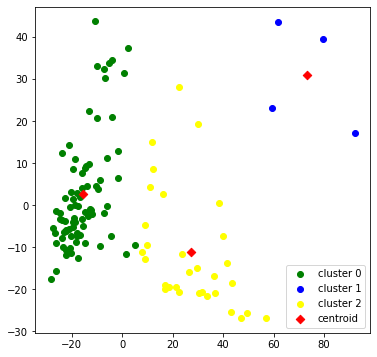

In [45]:
# Plot the clustered data
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(feat_resh[kmeans.labels_ == 0, 0], feat_resh[kmeans.labels_ == 0, 1],
            c='green', label='cluster 0')
plt.scatter(feat_resh[kmeans.labels_ == 1, 0], feat_resh[kmeans.labels_ == 1, 1],
            c='blue', label='cluster 1')
plt.scatter(feat_resh[kmeans.labels_ == 2, 0], feat_resh[kmeans.labels_ == 2, 1],
            c='yellow', label='cluster 2')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='D',
            c='r', label='centroid')
plt.legend()
#plt.xlim([-100, 150])
#plt.ylim([-50, 100])
#plt.xlabel('Eruption time in mins')
#plt.ylabel('Waiting time to next eruption')
#plt.title('Visualization of clustered data', fontweight='bold')
#ax.set_aspect('equal')
plt.savefig('./clustering_vis.png')

In [46]:
"""n_iter = 9
fig, ax = plt.subplots(3, 3, figsize=(16, 16))
ax = np.ravel(ax)
centers = []
for i in range(n_iter):
    # Run local implementation of kmeans
    km = Kmeans(n_clusters=2,
                max_iter=3,
                random_state=np.random.randint(0, 1000, size=1))
    km.fit(X_std)
    centroids = km.centroids
    centers.append(centroids)
    ax[i].scatter(X_std[km.labels == 0, 0], X_std[km.labels == 0, 1],
                  c='green', label='cluster 1')
    ax[i].scatter(X_std[km.labels == 1, 0], X_std[km.labels == 1, 1],
                  c='blue', label='cluster 2')
    ax[i].scatter(centroids[:, 0], centroids[:, 1],
                  c='r', marker='*', s=300, label='centroid')
    ax[i].set_xlim([-2, 2])
    ax[i].set_ylim([-2, 2])
    ax[i].legend(loc='lower right')
    ax[i].set_title(f'{km.error:.4f}')
    ax[i].set_aspect('equal')
plt.tight_layout()
plt.savefig('./training_clustering_vis.png')"""

"n_iter = 9\nfig, ax = plt.subplots(3, 3, figsize=(16, 16))\nax = np.ravel(ax)\ncenters = []\nfor i in range(n_iter):\n    # Run local implementation of kmeans\n    km = Kmeans(n_clusters=2,\n                max_iter=3,\n                random_state=np.random.randint(0, 1000, size=1))\n    km.fit(X_std)\n    centroids = km.centroids\n    centers.append(centroids)\n    ax[i].scatter(X_std[km.labels == 0, 0], X_std[km.labels == 0, 1],\n                  c='green', label='cluster 1')\n    ax[i].scatter(X_std[km.labels == 1, 0], X_std[km.labels == 1, 1],\n                  c='blue', label='cluster 2')\n    ax[i].scatter(centroids[:, 0], centroids[:, 1],\n                  c='r', marker='*', s=300, label='centroid')\n    ax[i].set_xlim([-2, 2])\n    ax[i].set_ylim([-2, 2])\n    ax[i].legend(loc='lower right')\n    ax[i].set_title(f'{km.error:.4f}')\n    ax[i].set_aspect('equal')\nplt.tight_layout()\nplt.savefig('./training_clustering_vis.png')"

# Cosine Similarity Matrix

In [47]:
# import
from numpy import dot
from numpy.linalg import norm
import numpy as np

# 코사인 유사도 함수 
def cos_sim(A, B):
    return dot(A, B)/(norm(A)*norm(B))

In [48]:
sim_matrix = np.zeros((3, 3))
sim_matrix

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [49]:
sim_matrix.shape

(3, 3)

In [50]:
dissim_img_idx

[112, 48, 55]

In [51]:
cluster0 = gram_matrix_list[112]
cluster0

array([[ 0.03318965, -0.00270147, -0.01480293, ..., -0.0044996 ,
        -0.00062504, -0.00126022],
       [-0.00270147,  0.05212079,  0.00683188, ...,  0.0033444 ,
        -0.00572   ,  0.00970474],
       [-0.01480293,  0.00683188,  0.03130432, ...,  0.0045579 ,
         0.00034498, -0.00271553],
       ...,
       [-0.0044996 ,  0.0033444 ,  0.0045579 , ...,  0.07085208,
         0.00479556,  0.00757613],
       [-0.00062504, -0.00572   ,  0.00034498, ...,  0.00479556,
         0.03867948,  0.00229289],
       [-0.00126022,  0.00970474, -0.00271553, ...,  0.00757613,
         0.00229289,  0.05730438]], dtype=float32)

In [52]:
cluster1 = gram_matrix_list[48]
cluster1

array([[ 0.13165988, -0.04244509, -0.04739966, ..., -0.05668983,
         0.03500219, -0.06479979],
       [-0.04244509,  0.1017535 ,  0.04188222, ...,  0.04076063,
        -0.02660288,  0.0922443 ],
       [-0.04739966,  0.04188222,  0.12178008, ...,  0.02709909,
        -0.02372577,  0.05501016],
       ...,
       [-0.05668983,  0.04076063,  0.02709909, ...,  0.43252936,
        -0.02812432,  0.12480449],
       [ 0.03500219, -0.02660288, -0.02372577, ..., -0.02812432,
         0.16114484, -0.03602307],
       [-0.06479979,  0.0922443 ,  0.05501016, ...,  0.12480449,
        -0.03602307,  0.2703672 ]], dtype=float32)

In [53]:
cluster2 = gram_matrix_list[55]
cluster2

array([[ 0.05358682, -0.00335491, -0.01650239, ...,  0.00372661,
         0.00112047,  0.00638578],
       [-0.00335491,  0.06937371,  0.01071004, ...,  0.0311146 ,
        -0.02566622,  0.04826358],
       [-0.01650239,  0.01071004,  0.04785493, ...,  0.00355238,
        -0.00741717,  0.00231606],
       ...,
       [ 0.00372661,  0.0311146 ,  0.00355238, ...,  0.22601289,
        -0.0153442 ,  0.04790053],
       [ 0.00112047, -0.02566622, -0.00741717, ..., -0.0153442 ,
         0.08429445, -0.03431514],
       [ 0.00638578,  0.04826358,  0.00231606, ...,  0.04790053,
        -0.03431514,  0.10741151]], dtype=float32)

In [54]:
cluster = []
cluster.append(cluster0)
cluster.append(cluster1)
cluster.append(cluster2)

In [55]:
len(cluster)

3

In [56]:
for i in range(len(cluster)):
    for j in range(len(cluster)):
        sim_matrix[i, j] = cos_sim(cluster[i].reshape(-1), cluster[j].reshape(-1))

In [57]:
sim_matrix

array([[0.99999988, 0.68548721, 0.72051346],
       [0.68548721, 1.        , 0.91952831],
       [0.72051346, 0.91952831, 1.        ]])

In [58]:
sim_matrix.shape

(3, 3)

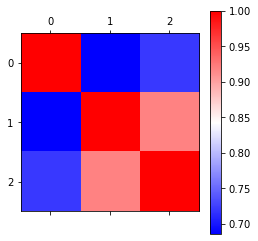

In [59]:
#cmap = plt.get_cmap('PiYG')
#cmap = plt.get_cmap('BuGn')
#cmap = plt.get_cmap('Greys')
cmap = plt.get_cmap('bwr')
#cmap = plt.get_cmap('rainbow')

plt.matshow(sim_matrix, cmap=cmap)
plt.colorbar()
#plt.show()
plt.savefig('./cosine_sim_matrix_vis.png')

## transfered image cosine sim matrix

### cranebird

In [60]:
#origin_img = Image.open('./transfered_img/cranebird_oriental_k018.jpg')
#origin_img_arr = np.asarray(origin_img)
#print(np.shape(origin_img_arr))

In [61]:
def normalize(image):
    normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
    ])
    image = Variable(preprocess(image).unsqueeze(0).cpu())
    return image

def load_image(path):
    image = Image.open(path).convert('RGB')
    plt.imshow(image)
    plt.title("Image loaded successfully")
    return image

In [63]:
vgg = models.vgg19(pretrained=True)

In [64]:
modulelist = list(vgg.features.modules())

In [75]:
modulelist[1:]

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1

tensor([[[[1.5810, 1.5468, 1.5639,  ..., 0.7419, 0.7419, 0.6563],
          [1.5810, 1.5468, 1.5810,  ..., 1.0159, 0.9646, 0.8961],
          [1.5982, 1.5639, 1.5639,  ..., 1.3413, 1.2899, 1.2043],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[1.7983, 1.7633, 1.7808,  ..., 0.8529, 0.8529, 0.7654],
          [1.7983, 1.7633, 1.7983,  ..., 1.0630, 1.0280, 0.9930],
          [1.8158, 1.7808, 1.7808,  ..., 1.3606, 1.3256, 1.2731],
          ...,
          [0.0000, 0.0301, 0.0000,  ..., 0.2227, 0.2577, 0.2402],
          [0.0301, 0.0126, 0.0000,  ..., 0.2402, 0.2752, 0.2577],
          [0.0126, 0.0000, 0.0000,  ..., 0.2227, 0.2577, 0.2402]],

         [[2.0997, 2.0648, 2.0823,  ..., 1.1237, 1.1237, 1.0365],
          [2.0997, 2.0648, 2.0997,  ..., 1.3328, 1.2980, 1.2282],
          [2.1171, 2.0823, 2.0823,  ..., 1

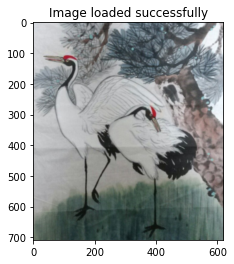

In [76]:
origin_img = load_image('./transfered_img/cranebird_oriental_k018.jpg')
origin_img_nor = normalize(origin_img)
origin_img_feature = modulelist[1:][13](origin_img_nor)
origin_img_feature

In [86]:
origin_img_feature_flat = origin_img_feature.to('cpu').numpy().flatten()
origin_img_feature_flat

array([1.5810429 , 1.5467933 , 1.5639181 , ..., 0.39163405, 0.37420484,
       0.32191727], dtype=float32)

tensor([[[[2.1462, 2.0948, 2.1290,  ..., 1.1358, 1.1700, 1.2557],
          [2.1290, 2.0605, 2.1290,  ..., 1.3242, 1.3584, 1.4098],
          [2.1633, 2.1119, 2.1119,  ..., 1.5982, 1.5982, 1.6324],
          ...,
          [1.4954, 1.5297, 1.4612,  ..., 1.1358, 1.2043, 1.3070],
          [1.4954, 1.4783, 1.3755,  ..., 1.1015, 1.2214, 1.2385],
          [1.5810, 1.5125, 1.4269,  ..., 1.1187, 1.2899, 1.2214]],

         [[1.9734, 1.9034, 1.9209,  ..., 0.9930, 0.9755, 0.9230],
          [1.9034, 1.8333, 1.8508,  ..., 1.1331, 1.1155, 1.0630],
          [1.9384, 1.8683, 1.8683,  ..., 1.3957, 1.3431, 1.3081],
          ...,
          [1.3431, 1.3782, 1.3606,  ..., 1.2556, 1.2556, 1.1856],
          [1.3782, 1.3957, 1.3256,  ..., 1.3081, 1.2556, 1.2031],
          [1.3256, 1.3431, 1.2556,  ..., 1.2556, 1.1856, 1.1681]],

         [[1.2282, 1.2282, 1.3502,  ..., 1.0539, 0.9842, 0.7925],
          [1.4200, 1.4200, 1.5420,  ..., 1.1411, 1.0888, 0.8797],
          [1.4200, 1.4374, 1.5245,  ..., 1

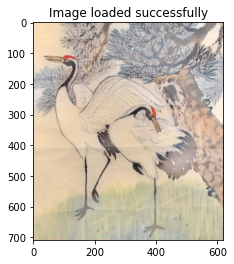

In [87]:
cluster0_img = load_image('./transfered_img/cranebird_oriental_k018_style0.jpg')
cluster0_img_nor = normalize(cluster0_img)
cluster0_img_feature = modulelist[1:][13](cluster0_img_nor)
cluster0_img_feature

In [88]:
cluster0_img_feature_flat = cluster0_img_feature.to('cpu').numpy().flatten()
cluster0_img_feature_flat

array([2.1461596, 2.0947855, 2.129035 , ..., 1.0539435, 1.0016559,
       0.9319392], dtype=float32)

In [ ]:
#cluster0_img = Image.open('./transfered_img/cranebird_oriental_k018_style0.jpg')
#cluster0_img_arr = np.asarray(cluster0_img)
#print(np.shape(cluster0_img_arr))

tensor([[[[1.2043, 1.1700, 1.2043,  ..., 1.2043, 1.1700, 1.0844],
          [1.2214, 1.1700, 1.2385,  ..., 1.3927, 1.3242, 1.2899],
          [1.2728, 1.2043, 1.2214,  ..., 1.6324, 1.5982, 1.5639],
          ...,
          [1.2043, 1.2214, 1.1015,  ..., 1.0502, 1.0673, 1.2214],
          [1.2728, 1.1529, 1.0331,  ..., 1.2214, 1.0502, 1.1700],
          [1.3070, 1.1187, 0.9817,  ..., 1.3242, 1.0331, 1.0844]],

         [[1.3957, 1.3431, 1.3782,  ..., 1.0980, 1.1155, 1.0630],
          [1.3957, 1.3256, 1.3957,  ..., 1.2731, 1.2731, 1.2381],
          [1.4307, 1.3431, 1.3606,  ..., 1.5357, 1.5182, 1.4657],
          ...,
          [1.1856, 1.2206, 1.1506,  ..., 1.2381, 1.2381, 1.1331],
          [1.2031, 1.2206, 1.1506,  ..., 1.2031, 1.3081, 1.1681],
          [1.1155, 1.2206, 1.2031,  ..., 1.1155, 1.3081, 1.1331]],

         [[1.4025, 1.4374, 1.5245,  ..., 1.1411, 1.1237, 0.8274],
          [1.4374, 1.4374, 1.5594,  ..., 1.3154, 1.2631, 1.0191],
          [1.5071, 1.4897, 1.5594,  ..., 1

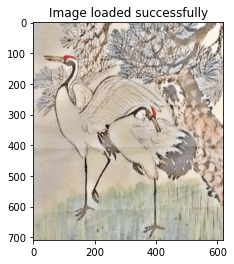

In [89]:
cluster1_img = load_image('./transfered_img/cranebird_oriental_k018_style1.jpg')
cluster1_img_nor = normalize(cluster1_img)
cluster1_img_feature = modulelist[1:][13](cluster1_img_nor)
cluster1_img_feature

In [90]:
cluster1_img_feature_flat = cluster1_img_feature.to('cpu').numpy().flatten()
cluster1_img_feature_flat

array([1.2042983, 1.1700488, 1.2042983, ..., 1.1585187, 0.8447932,
       0.9667976], dtype=float32)

In [ ]:
#cluster1_img = Image.open('./transfered_img/cranebird_oriental_k018_style1.jpg')
#cluster1_img_arr = np.asarray(cluster1_img)
#print(np.shape(cluster1_img_arr))

tensor([[[[2.1462, 2.0948, 2.1290,  ..., 1.1358, 1.1700, 1.2557],
          [2.1290, 2.0605, 2.1290,  ..., 1.3242, 1.3584, 1.4098],
          [2.1633, 2.1119, 2.1119,  ..., 1.5982, 1.5982, 1.6324],
          ...,
          [1.4954, 1.5297, 1.4612,  ..., 1.1358, 1.2043, 1.3070],
          [1.4954, 1.4783, 1.3755,  ..., 1.1015, 1.2214, 1.2385],
          [1.5810, 1.5125, 1.4269,  ..., 1.1187, 1.2899, 1.2214]],

         [[1.9734, 1.9034, 1.9209,  ..., 0.9930, 0.9755, 0.9230],
          [1.9034, 1.8333, 1.8508,  ..., 1.1331, 1.1155, 1.0630],
          [1.9384, 1.8683, 1.8683,  ..., 1.3957, 1.3431, 1.3081],
          ...,
          [1.3431, 1.3782, 1.3606,  ..., 1.2556, 1.2556, 1.1856],
          [1.3782, 1.3957, 1.3256,  ..., 1.3081, 1.2556, 1.2031],
          [1.3256, 1.3431, 1.2556,  ..., 1.2556, 1.1856, 1.1681]],

         [[1.2282, 1.2282, 1.3502,  ..., 1.0539, 0.9842, 0.7925],
          [1.4200, 1.4200, 1.5420,  ..., 1.1411, 1.0888, 0.8797],
          [1.4200, 1.4374, 1.5245,  ..., 1

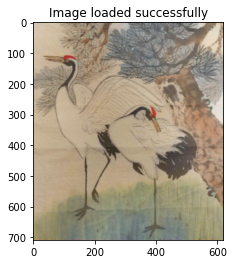

In [91]:
cluster2_img = load_image('./transfered_img/cranebird_oriental_k018_style2.jpg')
cluster2_img_nor = normalize(cluster0_img)
cluster2_img_feature = modulelist[1:][13](cluster2_img_nor)
cluster2_img_feature

In [92]:
cluster2_img_feature_flat = cluster2_img_feature.to('cpu').numpy().flatten()
cluster2_img_feature_flat

array([2.1461596, 2.0947855, 2.129035 , ..., 1.0539435, 1.0016559,
       0.9319392], dtype=float32)

In [ ]:
#cluster2_img = Image.open('./transfered_img/cranebird_oriental_k018_style2.jpg')
#cluster2_img_arr = np.asarray(cluster2_img)
#print(np.shape(cluster2_img_arr))

In [93]:
sim_matrix_2 = np.zeros((4, 4))
sim_matrix_2

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [94]:
transfered_img = []
transfered_img.append(origin_img_feature_flat)
transfered_img.append(cluster0_img_feature_flat)
transfered_img.append(cluster1_img_feature_flat)
transfered_img.append(cluster2_img_feature_flat)

In [95]:
for i in range(len(transfered_img)):
    for j in range(len(transfered_img)):
        sim_matrix_2[i, j] = cos_sim(transfered_img[i], transfered_img[j])

In [96]:
sim_matrix_2

array([[1.00000012, 0.81118757, 0.80283183, 0.81118757],
       [0.81118757, 1.        , 0.97413701, 1.        ],
       [0.80283183, 0.97413701, 1.00000012, 0.97413701],
       [0.81118757, 1.        , 0.97413701, 1.        ]])

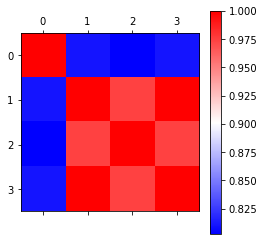

In [97]:
#cmap = plt.get_cmap('PiYG')
#cmap = plt.get_cmap('BuGn')
#cmap = plt.get_cmap('Greys')
cmap = plt.get_cmap('bwr')
#cmap = plt.get_cmap('rainbow')

plt.matshow(sim_matrix_2, cmap=cmap)
plt.colorbar()
#plt.show()
plt.savefig('./cosine_sim_matrix_cranebird_vis.png')

### deer

In [ ]:
origin_img = Image.open('./transfered_img/deer_oriental_j005.jpg')
origin_img_arr = np.asarray(origin_img)
print(np.shape(origin_img_arr))

In [ ]:
cluster0_img = Image.open('./transfered_img/deer_oriental_j005_style0.jpg')
cluster0_img_arr = np.asarray(cluster0_img)
print(np.shape(cluster0_img_arr))

In [ ]:
cluster1_img = Image.open('./transfered_img/deer_oriental_j005_style1.jpg')
cluster1_img_arr = np.asarray(cluster1_img)
print(np.shape(cluster1_img_arr))

In [ ]:
cluster2_img = Image.open('./transfered_img/deer_oriental_j005_style2.jpg')
cluster2_img_arr = np.asarray(cluster2_img)
print(np.shape(cluster2_img_arr))

In [ ]:
sim_matrix_2 = np.zeros((4, 4))
sim_matrix_2

In [ ]:
transfered_img = []
transfered_img.append(origin_img_arr)
transfered_img.append(cluster0_img_arr)
transfered_img.append(cluster1_img_arr)
transfered_img.append(cluster2_img_arr)

In [ ]:
len(transfered_img)

In [ ]:
for i in range(len(transfered_img)):
    for j in range(len(transfered_img)):
        sim_matrix_2[i, j] = cos_sim(transfered_img[i].flatten(), transfered_img[j].flatten())

In [ ]:
sim_matrix_2

In [ ]:
#cmap = plt.get_cmap('PiYG')
#cmap = plt.get_cmap('BuGn')
#cmap = plt.get_cmap('Greys')
cmap = plt.get_cmap('bwr')
#cmap = plt.get_cmap('rainbow')

plt.matshow(sim_matrix_2, cmap=cmap)
plt.colorbar()
#plt.show()
plt.savefig('./cosine_sim_matrix_deer_vis.png')

# Style Vis

In [ ]:
# 스타일 손실(style loss) 계산을 위한 클래스 정의
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
style_layers = ['conv_1', 'conv_3', 'conv_5']

# 스타일 손실(style loss)을 계산하는 함수
def get_style_losses(cnn, style_img, noise_image):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    style_losses = []
    
    # 가장 먼저 입력 이미지가 입력 정규화(input normalization)를 수행하도록
    model = nn.Sequential(normalization)

    # 현재 CNN 모델에 포함되어 있는 모든 레이어를 확인하며
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # 설정한 style layer까지의 결과를 이용해 style loss를 계산
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 마지막 style loss 이후의 레이어는 사용하지 않도록
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    return model, style_losses

In [ ]:
def style_reconstruction(cnn, style_img, input_img, iters, cls_name):
    model, style_losses = get_style_losses(cnn, style_img, input_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print("[ Start ]")
    imshow(input_img)

    # 하나의 값만 이용하기 위해 배열 형태로 사용
    run = [0]
    while run[0] <= iters:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0

            for sl in style_losses:
                style_score += sl.loss

            style_score *= 1e6
            style_score.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"[ Step: {run[0]} / Style loss: {style_score.item()}]")
                imshow(input_img)
                save_image(input_img, './style_vis/' + cls_name + '/' + f"iter_{run[0]}" + '.png')
            
            return style_score
        
        optimizer.step(closure)

    # 결과적으로 이미지의 각 픽셀의 값이 [0, 1] 사이의 값이 되도록 자르기
    input_img.data.clamp_(0, 1)

    return input_img

In [ ]:
dissim_center_img

In [ ]:
img_size = PIL.Image.open(style_img_path + 'b98.jpg').size
cluster0_img = image_loader(style_img_path + 'b98.jpg', (img_size[1], img_size[0]))

In [ ]:
img_size = PIL.Image.open(style_img_path + 'b34소림명월도.jpg').size
cluster1_img = image_loader(style_img_path + 'b34소림명월도.jpg', (img_size[1], img_size[0]))

In [ ]:
img_size = PIL.Image.open(style_img_path + 'b41점심.jpg').size
cluster2_img = image_loader(style_img_path + 'b41점심.jpg', (img_size[1], img_size[0]))

In [ ]:
input_img = torch.empty_like(cluster0_img).uniform_(0, 1).to(device)
output = style_reconstruction(cnn, style_img=cluster0_img, input_img=input_img, iters=1500, cls_name='cluster0')

In [ ]:
input_img = torch.empty_like(cluster1_img).uniform_(0, 1).to(device)
output = style_reconstruction(cnn, style_img=cluster1_img, input_img=input_img, iters=1500, cls_name='cluster1')

In [ ]:
input_img = torch.empty_like(cluster2_img).uniform_(0, 1).to(device)
output = style_reconstruction(cnn, style_img=cluster2_img, input_img=input_img, iters=1500, cls_name='cluster2')